In [121]:
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import scipy as sci
import autograd as ad
import autograd.numpy as np
from cosmatrix import cosm,expm_pade
expm = expm_pade
from autograd.extend import primitive, defvjp
def annihilation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),1)
def creation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),-1)
def coupled_spectrum(phi_ex,beta,N,Ej,Ec,El,omega_c,g_intfa):
    phi_ex = 2*np.pi*phi_ex
    def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
    @primitive
    def Us_min(phi_ex):
        def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
        phi_min = sci.optimize.minimize(U_s,0).x
        return phi_min
    
    def phi_minde(ans, phi_ex):
        def phi_minde_vjp(g):
            c2 = beta*np.cos(ans - phi_ex) + 1/N*np.cos(ans/N)
            return g*beta*np.cos(ans - phi_ex)/c2
        return phi_minde_vjp
    defvjp(Us_min, phi_minde)
    
    phi_min = Us_min(phi_ex)
    
    # potential expansion around minimum
    c2 = beta*np.cos(phi_min - phi_ex) + 1/N*np.cos(phi_min/N)
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/(Ej*c2),1/4)
    g2 = Ej*phi_zpf**2*c2/2
    sdim = 10
    s = annihilation(sdim)
    sd = creation(sdim)
    x2 = np.matmul(s+sd,s+sd)
    x3 = np.matmul(s+sd,x2)
    x4 = np.matmul(s+sd,x3)
    phi_min = Us_min(phi_ex)
    # potential expansion around minimum
    c2 = beta*np.cos(phi_min - phi_ex) + 1/N*np.cos(phi_min/N)
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/(Ej*c2),1/4)
    g2 = Ej*phi_zpf**2*c2/2
    firstd = ad.grad(U_s)
    secondd = ad.grad(firstd)
    thirdd = ad.grad(secondd)
    fourd = ad.grad(thirdd)
    fived = ad.grad(fourd)
    c2 = secondd(phi_min)
    c3 = thirdd(phi_min)
    c4 = fourd(phi_min)
    c5 = fived(phi_min)
    g2 = Ej*phi_zpf**2*c2/2
    g3 = Ej*phi_zpf**3*c3/3/2
    
    Hs = (omega_s * np.matmul(sd,s)
        - Ej*(beta*cosm(phi_zpf*(s+sd)+(phi_min-phi_ex)*np.identity(sdim))
        + N*cosm((phi_zpf*(s+sd)+phi_min*np.identity(sdim))/N))- g2*x2)
#     Hs = omega_s*np.matmul(sd,s) + g3*x3 + g4*x4
    energy = np.linalg.eigh(Hs)[0]
    energy = energy-energy[0]*np.ones(len(energy))
    omega_s = energy[1]
    anh = (energy[2]-energy[1]-energy[1]-energy[0])
    cdim = 5
    c = annihilation(cdim)
    cd = creation(cdim)
    Hc = omega_c*np.matmul(cd,c)
    Ic = np.identity(cdim)
    Is = np.identity(sdim)
    Hs = np.kron(Hs,Ic)
    Hc = np.kron(Is,Hc)
    g_int = g_intfa*2*np.pi*np.power((2*Ec)/Ej,1/4)/phi_zpf
    H_int = g_int*np.kron(s+sd,cd+c)
#     H_int = g_int*(np.kron(sd,c)+np.kron(s,cd))
    H = Hs + Hc + H_int
    energy,dressed_states = np.linalg.eigh(H)
    energy = energy-energy[0]*np.ones(len(energy))
    index = np.argmin(np.abs(energy-omega_c*np.ones(len(energy))))
    exact = energy[index]
    return exact
Egrad = ad.grad(coupled_spectrum)

def T1f(der):
    factor = np.sqrt(2*np.abs(np.log(2*np.pi*1*1e-5)))
    return 1/(factor*10**-6*der)
def Tw(der):
    return 3/1.7*1/((der*10**-8)**2*1e9)
def os(phi_ex,beta,N,Ej,Ec,El,omega_c):
    phi_ex = 2*np.pi*phi_ex
    @primitive
    def Us_min(phi_ex):
        def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
        phi_min = sci.optimize.minimize(U_s,0).x
        return phi_min
    def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
    def phi_minde(ans, phi_ex):
        def phi_minde_vjp(g):
            c2 = beta*np.cos(ans - phi_ex) + 1/N*np.cos(ans/N)
            return g*beta*np.cos(ans - phi_ex)/c2
        return phi_minde_vjp
    defvjp(Us_min, phi_minde)
    
    phi_min = Us_min(phi_ex)
    # potential expansion around minimum
    c2 = beta*np.cos(phi_min - phi_ex) + 1/N*np.cos(phi_min/N)
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/(Ej*c2),1/4)
    g2 = Ej*phi_zpf**2*c2/2
    firstd = ad.grad(U_s)
    secondd = ad.grad(firstd)
    thirdd = ad.grad(secondd)
    fourd = ad.grad(thirdd)
    fived = ad.grad(fourd)
    
    c2 = secondd(phi_min)
    c3 = thirdd(phi_min)
    c4 = fourd(phi_min)
    c5 = fived(phi_min)
    
    g2 = Ej*phi_zpf**2*c2/2
    g3 = Ej*phi_zpf**3*c3/3/2
    g4 = Ej*phi_zpf**4*c4/4/3/2
    g5 = Ej*phi_zpf**5*c5/5/4/3/2
    
    sdim = 10
    s = annihilation(sdim)
    sd = creation(sdim)
    x2 = np.matmul(s+sd,s+sd)
    Hs = (omega_s * np.matmul(sd,s)
        - Ej*(beta*cosm(phi_zpf*(s+sd)+(phi_min-phi_ex)*np.identity(sdim))
        + N*cosm((phi_zpf*(s+sd)+phi_min*np.identity(sdim))/N))- g2*x2)
    energy = np.linalg.eigh(Hs)[0]
    energy = energy-energy[0]*np.ones(len(energy))
    omega_s = energy[1]
    anh = (energy[2]-energy[1]-energy[1]-energy[0])/2/np.pi
    return omega_s,anh
def god(phi_ex,beta,N,Ej,Ec,El,omega_c,g_intfa):
    phi_ex = 2*np.pi*phi_ex
    def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
    @primitive
    def Us_min(phi_ex):
        def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
        phi_min = sci.optimize.minimize(U_s,0).x
        return phi_min
    
    def phi_minde(ans, phi_ex):
        def phi_minde_vjp(g):
            c2 = beta*np.cos(ans - phi_ex) + 1/N*np.cos(ans/N)
            return g*beta*np.cos(ans - phi_ex)/c2
        return phi_minde_vjp
    defvjp(Us_min, phi_minde)
    
    phi_min = Us_min(phi_ex)
    # potential expansion around minimum
    c2 = beta*np.cos(phi_min - phi_ex) + 1/N*np.cos(phi_min/N)
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/(Ej*c2),1/4)
    g2 = Ej*phi_zpf**2*c2/2
    sdim = 10
    s = annihilation(sdim)
    sd = creation(sdim)
    x2 = np.matmul(s+sd,s+sd)
    
    # potential expansion around minimum
    firstd = ad.grad(U_s)
    secondd = ad.grad(firstd)
    thirdd = ad.grad(secondd)
    fourd = ad.grad(thirdd)
    fived = ad.grad(fourd)
    c2 = secondd(phi_min)
    c3 = thirdd(phi_min)
    c4 = fourd(phi_min)
    six = ad.grad(fived)
    c6 = six(phi_min)
    
    c5 = fived(phi_min)
    g2 = Ej*phi_zpf**2*c2/2
    g3 = Ej*phi_zpf**3*c3/3/2
    g4 = Ej*phi_zpf**4*c4/4/3/2
    g5 = Ej*phi_zpf**5*c5/5/4/3/2
    g6 = Ej*phi_zpf**5*c5/6/5/4/3/2
    Hs = (omega_s * np.matmul(sd,s)
        - Ej*(beta*cosm(phi_zpf*(s+sd)+(phi_min-phi_ex)*np.identity(sdim))
        + N*cosm((phi_zpf*(s+sd)+phi_min*np.identity(sdim))/N))- g2*x2)
    energy = np.linalg.eigh(Hs)[0]
    energy = energy-energy[0]*np.ones(len(energy))
    omega_s = energy[1]
    anh = (energy[2]-energy[1]-energy[1]-energy[0])
    g_int = g_intfa*2*np.pi*np.power((2*Ec)/Ej,1/4)/phi_zpf
    delta = omega_s - omega_c
    return g_int/delta,delta/2/np.pi,g_int/2/np.pi,g3,g4,g5,np.sqrt(8*c2*Ej*Ec),omega_s,c2
import scipy.optimize as opt
def minimize_anh( beta, N, Ej, Ec, El, omega_c):
    # Wrapper function that takes only phi_ex as an argument
    def anh_wrapper(phi_ex):
        omega_s, anh = os(phi_ex, beta, N, Ej, Ec, El, omega_c)
        return np.abs(anh)
    bounds = [(0,0.5)]
    # Optimize phi_ex
    result = opt.direct(anh_wrapper, bounds = bounds)

    # Return the result of the optimization
    return result.x, result.fun
def minimize_Tp1(omega_c, beta, N, Ej, Ec, El, phi_ex,g_intfac):
    # Wrapper function that takes only phi_ex as an argument
    def anh_wrapper(omega_c):
        der = Egrad(phi_ex,beta,N,Ej,Ec,El,omega_c,g_intfac)
        T1fs = np.abs(T1f(der))
        return 1/T1fs*1e9

    # Optimize phi_ex
    bounds = [(0.1*2*np.pi,8*2*np.pi)]
    result = opt.minimize(anh_wrapper,omega_c,bounds=bounds)

    # Return the result of the optimization
    return result.x, result.fun
def minimize_Tp(beta, N, El, g_intfac):
    # Wrapper function that takes a vector of parameters (omega_c, Ej, Ec)
    def anh_wrapper(params):
        omega_c, Ej, Ec = params
        phi_ex,anh=minimize_anh( beta, N, Ej, Ec, El, 0)
        der = Egrad(phi_ex, beta, N, Ej, Ec, El, omega_c, g_intfac)
        ratio,delta,g_int,g3,g4,g5,omega_bs,omega_s=god(phi_ex,beta,N,Ej,Ec,El,omega_c,g_intfac)
        T1fs = np.abs(T1f(der))
        return 1 / T1fs * 1e9+1e4*np.exp(-10*g_intfac/(omega_s-omega_c))

    # Initial guesses for omega_c, Ej, Ec
    initial_guess = [3 * 2 * np.pi, 20 * 2 * np.pi, 0.5 * 2 * np.pi]  # Example values, adjust as needed

    # Define the bounds for omega_c, Ej, Ec
    bounds = [(2.5 * 2 * np.pi, 3.5 * 2 * np.pi),  # Bounds for omega_c
              (18 * 2 * np.pi, 100 * 2 * np.pi),    # Bounds for Ej
              (0.1 * 2 * np.pi, 0.5 * 2 * np.pi)]   # Bounds for Ec

    # Optimize the parameters
    result = opt.minimize(anh_wrapper, initial_guess, bounds=bounds)

    # Return the result of the optimization
    return result.x, result.fun

In [122]:
beta = 0.12
Ej = 90*2*np.pi
Ec = 0.177*2*np.pi
N = 3
phi_ex = 0.4
El=1e1*2*np.pi
phi_ex,anh=minimize_anh( beta, N, Ej, Ec, El, 0)
phi_ex=phi_ex[0]
omega_c = 3*2*np.pi
g_intfa=0.15
omega_c=minimize_Tp1(omega_c, beta, N, Ej, Ec, El, phi_ex,g_intfa)[0][0]
der = Egrad(phi_ex,beta,N,Ej,Ec,El,omega_c,g_intfa)
ratio,delta,g_int,g3,g4,g5,omega_bs,omega_s,c2=god(phi_ex,beta,N,Ej,Ec,El,omega_c,g_intfa)
omega_cp=os(phi_ex,beta,N,Ej,Ec,El,0)[0]+delta*2*np.pi
der2 = Egrad(phi_ex,beta,N,Ej,Ec,El,omega_cp,g_intfa)
T1fs = np.abs(T1f(der))
T1fsp = np.abs(T1f(der2))
delt = 1e-4
s_grad = np.abs((os(phi_ex+delt,beta,N,Ej,Ec,El,0)[0]-os(phi_ex,beta,N,Ej,Ec,El,0)[0])/delt)
γ_s=T1f(s_grad)/1e3
def format_number(num):
    if num == 0:
        return "0.00000"
    else:
        # Find the first non-zero digit after the decimal point
        decimal_places = -int(np.floor(np.log10(abs(num)))) + 4
        # Ensure a minimum of 5 decimal places
        decimal_places = max(decimal_places, 5)
        return f"{num:.{decimal_places}f}"
print('β: ' + format_number(beta))
print('Ej: ' + format_number(Ej / 2 / np.pi) + ' GHz')
print('Ec: ' + format_number(Ec / 2 / np.pi) + ' GHz')
print('g3: ' + format_number(g3[0] / 2 / np.pi) + ' GHz')
print('g4: ' + format_number(g4[0] / 2 / np.pi) + ' GHz')
print('g5: ' + format_number(g5[0] / 2 / np.pi) + ' GHz')
print('ω_s: ' + format_number(omega_s/2/np.pi) + ' GHz')
print('α: ' + format_number(anh/2/np.pi) + ' GHz')
print('T_ϕs: '+ format_number(γ_s) + 'μs')
# print('ω_s: ' + format_number((delta+omega_c) / 2 / np.pi) + ' GHz')
print('\n')
print("T_ϕ: " + format_number(T1fs / 1e9) + ' s'+' v.s '+str(T1fsp / 1e6)+" ms")
print('ω_c: ' + format_number(omega_c / 2 / np.pi) + ' GHz')
print('g_int: ' + format_number(g_int[0] ) + ' GHz')
print('Δ: ' + format_number(delta) + ' GHz')
print('g/Δ: ' + format_number(ratio[0]))

β: 0.12000
Ej: 90.00000 GHz
Ec: 0.17700 GHz
g3: 0.054820 GHz
g4: 0.0020917 GHz
g5: -0.00037580 GHz
ω_s: 5.73413 GHz
α: 0.00000000056193 GHz
T_ϕs: 4.81570μs


T_ϕ: 35445933.20432 s v.s 3.999615208114733 ms
ω_c: 1.73760 GHz
g_int: 0.10694 GHz
Δ: 3.99653 GHz
g/Δ: 0.026758


In [117]:
Egrad(phi_ex,beta,N,Ej,Ec,El,2.5*2*np.pi,g_intfac)/2/np.pi

-0.0017172977059995045

In [120]:
phi_ex

0.38059900660029355

In [108]:

beta = 0.12
Ej = 15*2*np.pi
Ec = 0.7*2*np.pi
N = 3
phi_ex = 0.38059900660029355
omega_cs = np.array([2.5*2*np.pi,2.9*2*np.pi])
T1fs =  np.zeros(len(omega_cs))
Tws = np.zeros(len(omega_cs))
der = np.zeros(len(omega_cs))
gods = np.zeros(len(omega_cs))
gs = np.zeros(len(omega_cs))
deltas = np.zeros(len(omega_cs))
g_intfac = 0.15
for i in range(len(omega_cs)):
    der[i] = Egrad(phi_ex,beta,N,Ej,Ec,El,omega_cs[i],g_intfac)
    print(der[i]/2/np.pi)
#     gods[i], gs[i],deltas[i]= god(phi_ex,beta,N,Ej,Ec,El,omega_cs[i],g_intfac)
    T1fs[i] = np.abs(T1f(der[i]))
    Tws[i] = np.abs(Tw(der[i]))

0.0012960109198637943
-0.001680208097869463


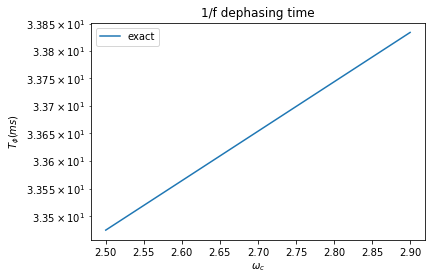

In [103]:
plt.plot(omega_cs/2/np.pi,(T1fs)/1e6,label= 'exact')

# plt.plot(omega_cs/2/np.pi,1/(gods**2)*(γ_s/1e3),label = '$(Δ/g)^2 3μs$')
plt.yscale('log')
plt.title('1/f dephasing time')
plt.ylabel('$T_\phi(ms)$')
plt.xlabel('$\omega_c$')
plt.legend()

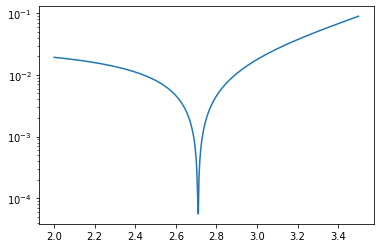

In [57]:
plt.plot(omega_cs/2/np.pi,np.abs(der),label= 'exact')
plt.yscale('log')

In [56]:
1/(3)-1/5

0.1333333333333333

In [ ]:
def get_cf(beta,Ej,Ec,):
    phi_ex,anh=minimize_anh( beta, N, Ej, Ec, El, 0)
    phi_ex=phi_ex[0]
    omega_c = 3*2*np.pi
    g_intfa=0.15
    omega_c=minimize_Tp1(omega_c, beta, N, Ej, Ec, El, phi_ex,g_intfa)[0][0]
    der = Egrad(phi_ex,beta,N,Ej,Ec,El,omega_c,g_intfa)
    ratio,delta,g_int,g3,g4,g5,omega_bs,omega_s=god(phi_ex,beta,N,Ej,Ec,El,omega_c,g_intfa)
    omega_cp=os(phi_ex,beta,N,Ej,Ec,El,0)[0]+delta*2*np.pi
    der2 = Egrad(phi_ex,beta,N,Ej,Ec,El,omega_cp,g_intfa)
    T1fs = np.abs(T1f(der))
    T1fsp = np.abs(T1f(der2))
    delt = 1e-4
    s_grad = np.abs((os(phi_ex+delt,beta,N,Ej,Ec,El,0)[0]-os(phi_ex,beta,N,Ej,Ec,El,0)[0])/delt)
    γ_s=T1f(s_grad)/1e3
    return np.sqrt(2*Ec*omega_s)/2/np.pi,omega_c/2/np.pi,γ_s
# Initialize lists to store results
sqrt_2Ec_omega_s = []
omega_c_values = []

beta = np.linspace(0.1, 0.2, 10)
Ej = np.linspace(20, 90, 10) * 2 * np.pi
Ec = np.linspace(0.3, 0.8, 10) * 2 * np.pi
N = 3
phi_ex = 0.4
El = 1e100 * 2 * np.pi
def compute_values(i,j,k):
    results = []
    b=beta_array[i]
    ej=Ej_array[i]
    ec=Ec_array[i]
    result = get_cf(b, ej, ec)
    results.append((b, ej, ec, result[0], result[1]))  # Store beta, Ej, Ec, and results
    return results

# Define your parameter arrays
beta_array = np.linspace(0.1, 0.2, 10) * 2 * np.pi
Ej_array = np.linspace(9, 90, 10) * 2 * np.pi
Ec_array = np.linspace(0.3, 0.8, 10) * 2 * np.pi

# Parallelize the computation
n_jobs = -1  # This will use all available cores
results = Parallel(n_jobs=n_jobs)(delayed(compute_values)(i,j,k) for i in range(len(beta_array)) for j in range(len(Ej_array)) for k in range(len(Ec_array)))



In [7]:
compute_values(0,0,0)

ERROR! Session/line number was not unique in database. History logging moved to new session 2300


[(0.6283185307179586,
  56.548667764616276,
  1.8849555921538759,
  1.0298563929903433,
  2.8147289911766564)]

In [8]:
a=1

In [68]:
compute_values()

0.1 125.66370614359172 1.8849555921538759
ERROR! Session/line number was not unique in database. History logging moved to new session 2284
0.1 125.66370614359172 2.2340214425527414
0.1 125.66370614359172 2.5830872929516078
0.1 125.66370614359172 2.9321531433504737
0.1 125.66370614359172 3.281218993749339
0.1 125.66370614359172 3.630284844148205
0.1 125.66370614359172 3.979350694547071
0.1 125.66370614359172 4.328416544945937
0.1 125.66370614359172 4.6774823953448035
0.1 125.66370614359172 5.026548245743669
0.1 174.53292519943295 1.8849555921538759
0.1 174.53292519943295 2.2340214425527414
0.1 174.53292519943295 2.5830872929516078
0.1 174.53292519943295 2.9321531433504737
0.1 174.53292519943295 3.281218993749339
0.1 174.53292519943295 3.630284844148205
0.1 174.53292519943295 3.979350694547071
0.1 174.53292519943295 4.328416544945937
0.1 174.53292519943295 4.6774823953448035
0.1 174.53292519943295 5.026548245743669
0.1 223.40214425527418 1.8849555921538759
0.1 223.40214425527418 2.234021

SystemError: <built-in function direct> returned a result with an error set

ERROR! Session/line number was not unique in database. History logging moved to new session 2281


ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

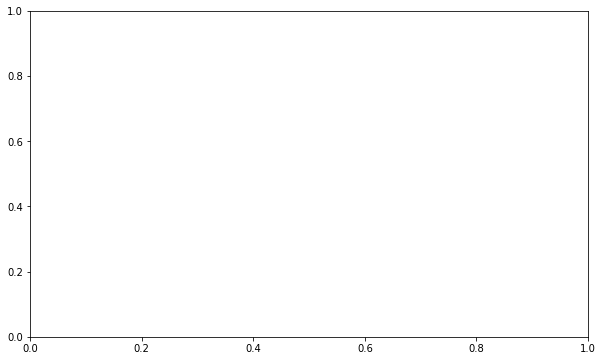

In [62]:
# Plotting
plt.figure(figsize=(10, 6))
# plt.plot(Ej / (2 * np.pi), , label='sqrt(2Ec*omega_s)/2pi')
plt.plot(Ej / (2 * np.pi), (np.array(omega_c_values)-sqrt_2Ec_omega_s)/(np.array(omega_c_values)), label='omega_c')
plt.xlabel('Ej')
plt.ylabel('Values')
plt.title('Plot of sqrt(2Ec*omega_s)/2pi and omega_c against Ej')
plt.legend()
plt.show()